In [1]:
import os
import copy
from typing import Type, Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import torch
import pyro
import seaborn as sns
import torch
import contextlib

from pyro.infer.autoguide import AutoDiagonalNormal
from chirho.robust.handlers.predictive import PredictiveModel

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

import pyro

from chirho.interventional.handlers import do
from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.add_categorical_interactions import AddCategoricalInteractions
from cities.modeling.add_causal_layer import AddCausalLayer 
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data
from pyro.infer import Predictive

import contextlib


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
n = 6
part = n // 3
n_steps = 600

x_cat = torch.cat(
    [
        torch.zeros([part], dtype=torch.long),
        torch.ones([part], dtype=torch.long),
        2 * torch.ones([part], dtype=torch.long),
    ]
)
x_con = torch.cat([torch.ones(n//2), torch.ones(n//2) * 2]) + torch.randn(n) * 0.1 + 0.5 * x_cat 


y_mixed = x_cat * 2 + x_con * 2 + torch.randn(n) * 0.05

synthetic_minimal_outcome = {
    "categorical": {"x_cat": x_cat},
    "continuous": {"x_con": x_con, "y_mixed": y_mixed   },
    "outcome": y_mixed,
}

minimal_kwargs_synthetic = {
    "categorical": {"x_cat"},
    "continuous": {"x_con"},
    "outcome": "y_mixed",
}


[iteration 0001] loss: 203.6757


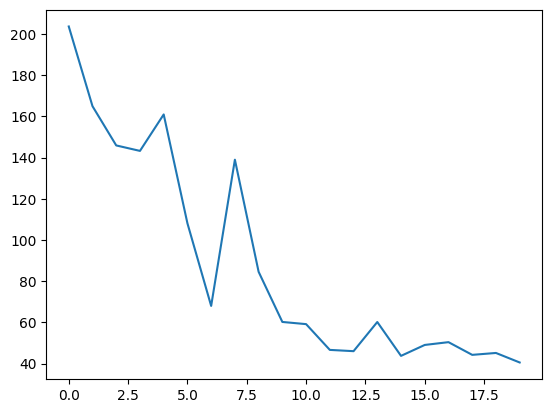

In [3]:
pyro.clear_param_store()

base_model_synthetic = SimpleLinear(**synthetic_minimal_outcome)

def new_model_synthetic(**kwargs):
    with AddCausalLayer(
        base_model_synthetic,
        model_kwargs=minimal_kwargs_synthetic,
        dataset=synthetic_minimal_outcome,
        causal_layer={"x_con": ["x_cat"]},
    ):
        base_model_synthetic(**synthetic_minimal_outcome)

new_guide_synthetic = run_svi_inference(
    new_model_synthetic,  **synthetic_minimal_outcome, n_steps=20) 


In [6]:
synthetic_minimal = copy.deepcopy(synthetic_minimal_outcome)
synthetic_minimal['outcome'] = None

predictive_synthetic = PredictiveModel(
new_model_synthetic, guide=new_guide_synthetic,
    )

samples_synthetic = predictive_synthetic(**synthetic_minimal)

# this will faile
#assert samples_synthetic is not None


with pyro.poutine.trace() as tr:
    samples_synthetic = predictive_synthetic(**synthetic_minimal)

print(synthetic_minimal_outcome['outcome'])
print(tr.trace.nodes['outcome_observed']['value'])

In [2]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())

print(data['categorical'].keys())
print(data['continuous'].keys())


minimal_kwargs = {  
    "categorical": ["past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

minimal_subset = select_from_data(data, minimal_kwargs)

# will want to add zone_id -> parcel_area and zone_id -> housing_units
expanded_kwargs = {  
    "categorical": ["zone_id", "past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

expanded_subset = select_from_data(data, expanded_kwargs)

print(expanded_subset['outcome'].shape)

dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])
dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
torch.Size([302])


In [3]:
base_model = SimpleLinear(**minimal_subset)

base_model(**minimal_subset)
print(minimal_subset['categorical'].keys())
print(minimal_subset['continuous'].keys())

dict_keys(['past_reform'])
dict_keys(['parcel_area'])


[iteration 0001] loss: 28729.3496
[iteration 0050] loss: 33250.7969
[iteration 0100] loss: 6763.9331
[iteration 0150] loss: 2443.6248
[iteration 0200] loss: 1888.2600
[iteration 0250] loss: 1712.8430
[iteration 0300] loss: 3820.8184
[iteration 0350] loss: 4865.5898
[iteration 0400] loss: 2267.7917
[iteration 0450] loss: 3025.5803
[iteration 0500] loss: 2049.4773


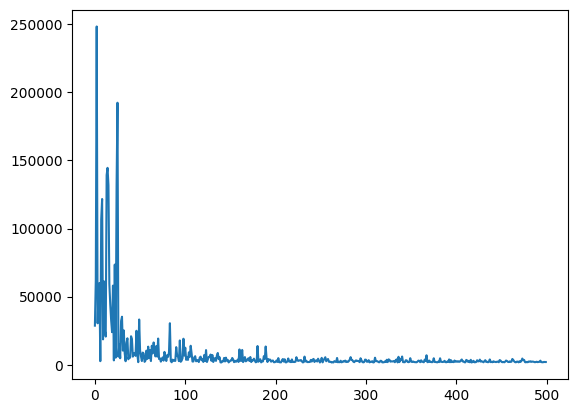

In [4]:
# minimal with non-trivial causal layer

def new_model(**kwargs):
    with AddCausalLayer(base_model,
        model_kwargs = minimal_kwargs,
        dataset = data,
        causal_layer={"parcel_area": ["zone_id", "neighborhood_id", "car_parking_original"], "housing_units": ["zone_id", "car_parking_original"]}):
            base_model(**minimal_subset)

with pyro.poutine.trace() as tr:
    new_model(**minimal_subset)

assert torch.allclose(tr.trace.nodes['parcel_area']['value'], data['continuous']['parcel_area'])
assert torch.allclose(tr.trace.nodes['outcome_observed']['value'], data['continuous']['housing_units'])


pyro.clear_param_store()

new_guide = run_svi_inference(new_model, **minimal_subset)


In [5]:
predictive = Predictive(
    new_model, guide=new_guide, num_samples=num_samples, parallel=True
)

samples = predictive(**minimal_subset)

print(
samples.keys()
)

assert samples['weights_categorical_zone_id_parcel_area'].squeeze().shape  == (1000,4)


dict_keys(['weights_categorical_neighborhood_id_parcel_area', 'weights_categorical_zone_id_parcel_area', 'bias_continuous_parcel_area', 'weight_continuous_parcel_area', 'sigma_parcel_area', 'weights_categorical_zone_id_housing_units', 'bias_continuous_housing_units', 'weight_continuous_housing_units', 'sigma_housing_units', 'sigma', 'weights_categorical_past_reform', 'bias_continuous', 'weight_continuous', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'mean_outcome_prediction_housing_units', 'housing_units', 'mean_outcome_prediction', 'outcome_observed'])


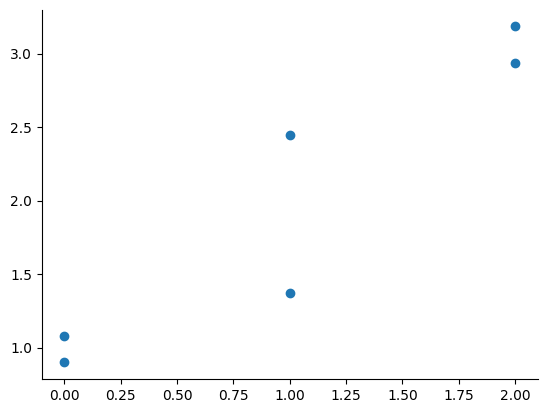

In [7]:
plt.scatter(x = x_cat.numpy(),y = x_con.numpy())
sns.despine()
plt.show()

[iteration 0001] loss: 236.2957
[iteration 0050] loss: 36.3096
[iteration 0100] loss: 30.7703
[iteration 0150] loss: 28.5363
[iteration 0200] loss: 28.3607
[iteration 0250] loss: 24.6825
[iteration 0300] loss: 26.0192
[iteration 0350] loss: 28.6961
[iteration 0400] loss: 28.2313
[iteration 0450] loss: 26.5997
[iteration 0500] loss: 45.7342


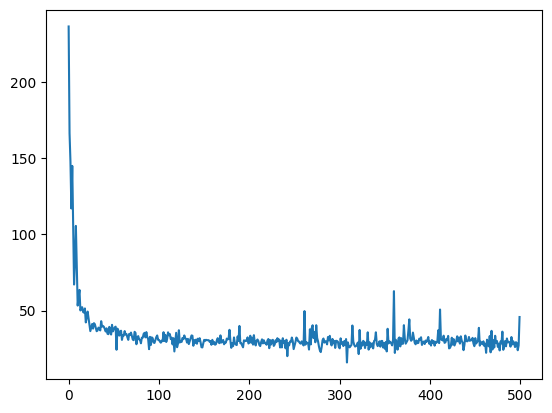

In [8]:
pyro.clear_param_store()

base_model_synthetic = SimpleLinear(**synthetic_minimal_outcome)

def new_model_synthetic(**kwargs):
    with AddCausalLayer(
        base_model_synthetic,
        model_kwargs=minimal_kwargs_synthetic,
        dataset=synthetic_minimal_outcome,
        causal_layer={"x_con": ["x_cat"]},
    ):
        base_model_synthetic(**synthetic_minimal_outcome)

new_guide_synthetic = run_svi_inference(
    new_model_synthetic, vi_family=AutoDiagonalNormal, **synthetic_minimal_outcome) 

# note AutoMultivariateNormal fails, not clear why


In [9]:


print(synthetic_minimal.keys())

dict_keys(['categorical', 'continuous', 'outcome'])


In [10]:
w_x_cat_to_x_con = samples_synthetic['weights_categorical_x_cat_x_con'].squeeze()

cat0_mean = w_x_cat_to_x_con[:, 0].mean()
cat1_mean = w_x_cat_to_x_con[:, 1].mean()
cat2_mean = w_x_cat_to_x_con[:, 2].mean()

# assert torch.allclose(torch.tensor([cat0_mean, cat1_mean, cat2_mean]),
#                 torch.tensor([1.0, 2.0, 3.0]), atol=0.2)

In [17]:
predictive_model_synthetic = PredictiveModel(new_model_synthetic, guide=new_guide_synthetic)

print(synthetic_minimal.keys())

synthetic_no_x_con = copy.deepcopy(synthetic_minimal)
synthetic_no_x_con['continuous']['x_con'] = None

print(synthetic_no_x_con)

predictive_model_synthetic(**synthetic_no_x_con)

#this for some reason does not abandon the x_con variable in kwargs

dict_keys(['categorical', 'continuous', 'outcome'])
{'categorical': {'x_cat': tensor([0, 0, 1, 1, 2, 2])}, 'continuous': {'x_con': None, 'y_mixed': tensor([ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875])}, 'outcome': None}


In [13]:
print("original_xcon", synthetic_minimal_outcome['continuous']['x_con'])
print('original_outcome',
      synthetic_minimal_outcome['outcome'])

predictive_synthetic = Predictive(new_model_synthetic, guide=new_guide_synthetic, num_samples = 4)

print(synthetic_minimal.keys())

synthetic_no_x_con = copy.deepcopy(synthetic_minimal)
synthetic_no_x_con['continuous']['x_con'] = None


samples = predictive_synthetic(**synthetic_no_x_con)

print("sampled xcon", samples['x_con'])
print("sampled_outcome", samples['outcome_observed'])


original_xcon tensor([1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839])
original_outcome tensor([ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875])
dict_keys(['categorical', 'continuous', 'outcome'])
sampled xcon tensor([[1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839],
        [1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839],
        [1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839],
        [1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839]])
sampled_outcome tensor([[ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875],
        [ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875],
        [ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875],
        [ 2.2373,  1.8339,  4.6932,  6.8147,  9.8303, 10.2875]])


In [14]:

with pyro.poutine.trace() as tr_before:
#        with pyro.plate("samples", 1 dim=-15): 
               # plate inane for observed outcome, 
               # placed to see if it breaks anything
        predictive_model_synthetic(**synthetic_no_x_con)


xcon_before = tr_before.trace.nodes['x_con']['value']

print(synthetic_minimal_outcome['continuous']['x_con'])

tensor([1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839])


tensor([3., 3., 3.])
odict_keys(['AutoDiagonalNormal.loc', 'AutoDiagonalNormal.scale', '_AutoDiagonalNormal_latent', 'weights_categorical_x_cat_x_con', 'sigma_x_con', 'sigma', 'weights_categorical_x_cat', 'bias_continuous', 'weight_continuous', 'data_1', 'mean_outcome_prediction_x_con', 'x_con', 'data', 'mean_outcome_prediction', 'outcome_observed'])
tensor([1.0766, 0.8993, 1.3747, 2.4494, 2.9327, 3.1839])


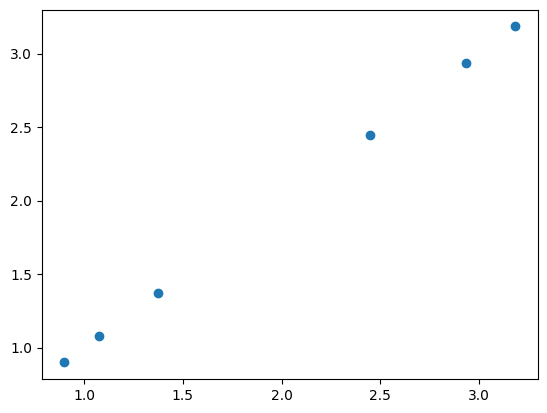

In [15]:

#before = tr.trace.nodes['outcome_observed']['value']

with do(actions={'weights_categorical_x_cat_x_con': torch.tensor([3.0]).expand(3)}):
        with pyro.poutine.trace() as tr_intervened_on_weight:
            predictive_model_synthetic(**synthetic_no_x_con)

xcon_after = tr_intervened_on_weight.trace.nodes['x_con']['value']

plt.scatter(x = xcon_before.numpy(),y = xcon_after.numpy())

print(tr_intervened_on_weight.trace.nodes['weights_categorical_x_cat_x_con']['value'])

print(tr_intervened_on_weight.trace.nodes.keys())

print(tr_intervened_on_weight.trace.nodes['x_con']['value'])

In [ ]:

after_weight = tr_intervened_on_weight.trace.nodes['outcome_observed']['value']

print(after_weight.shape)

plt.scatter(x = before.detach().numpy(), y = after_weight.detach().numpy())
#plt.hist(samples)'outcome_observed'